
==== Experiment 4: Positional Embedding Types ====
Using device: cuda

Training with 1D Learned positional embedding:
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/1


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 30.51it/s, Loss=1.81, Acc=32.8]


Saving best model with accuracy: 32.83%
Best test accuracy with 1D Learned: 32.83%

Best Test Accuracies:
1D Learned: 32.83%

==== Experiment 5: Visualizations ====


/tmp/ipykernel_31/3483551931.py:1247: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("vit_1d_learned.pth"))


Files already downloaded and verified
Files already downloaded and verified
Visualizing attention maps...


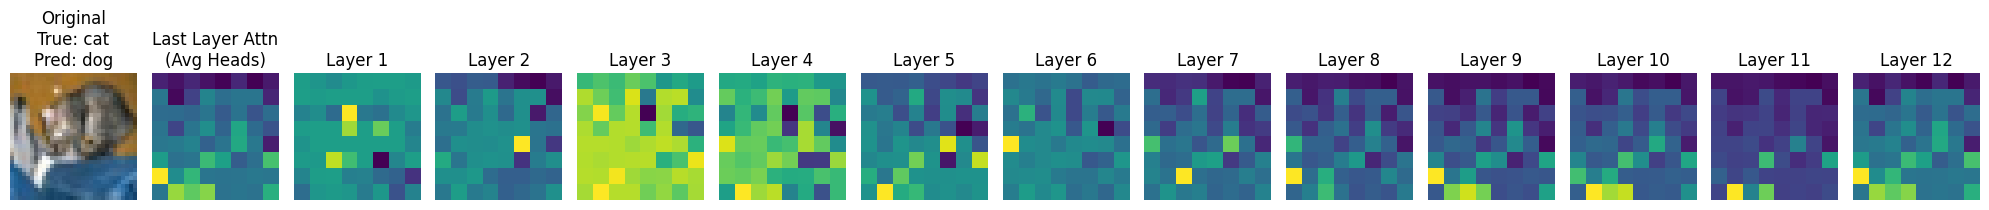

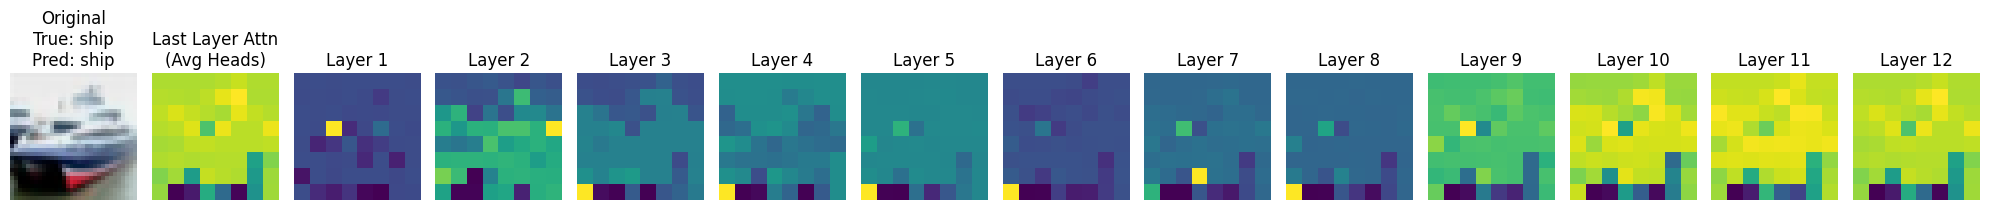

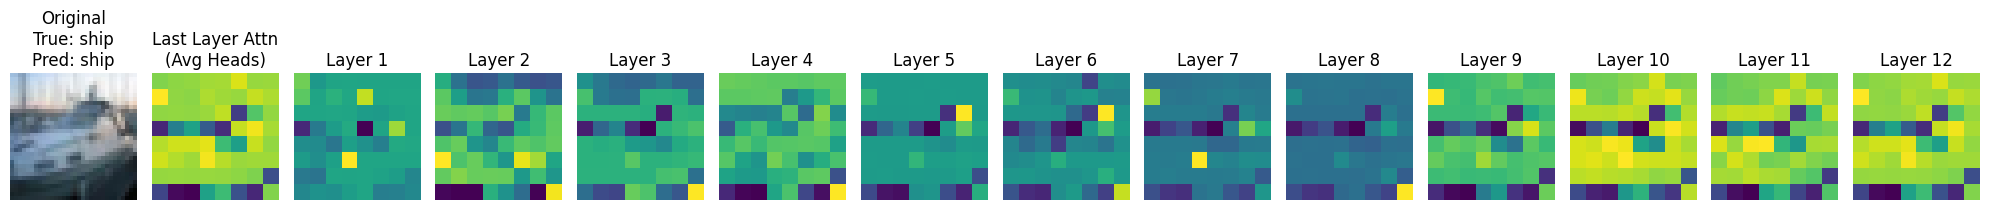

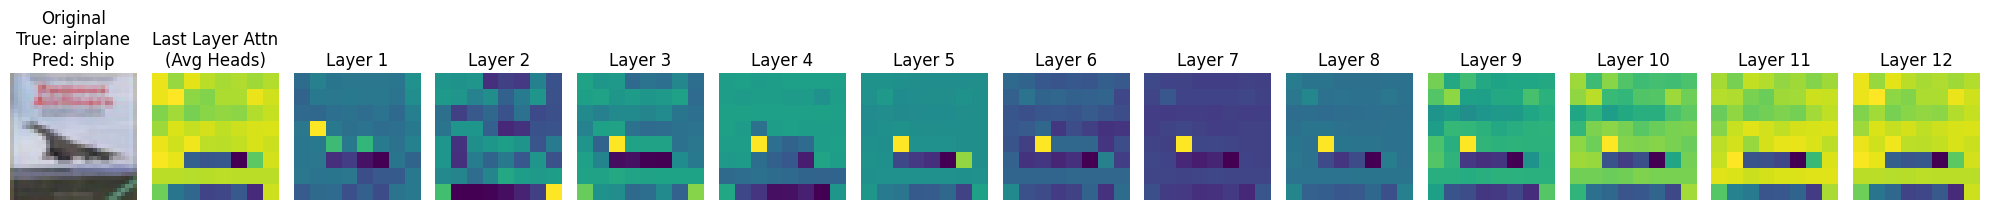

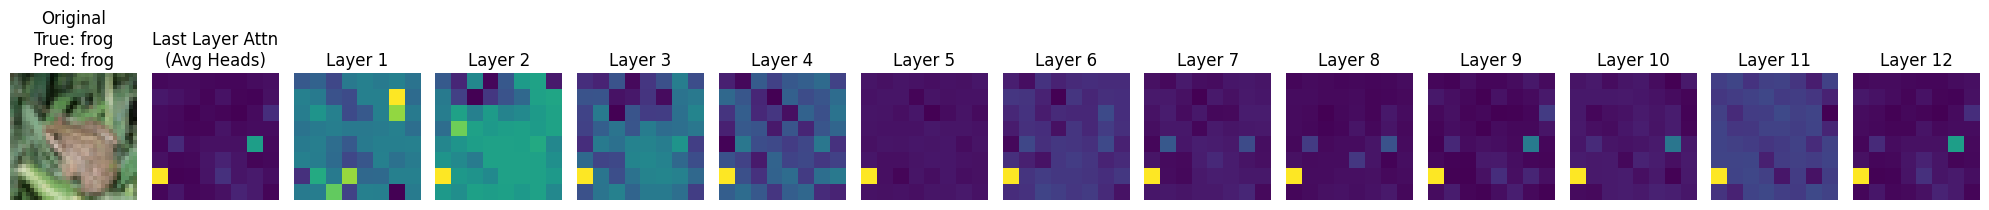

Visualizing attention rollout...


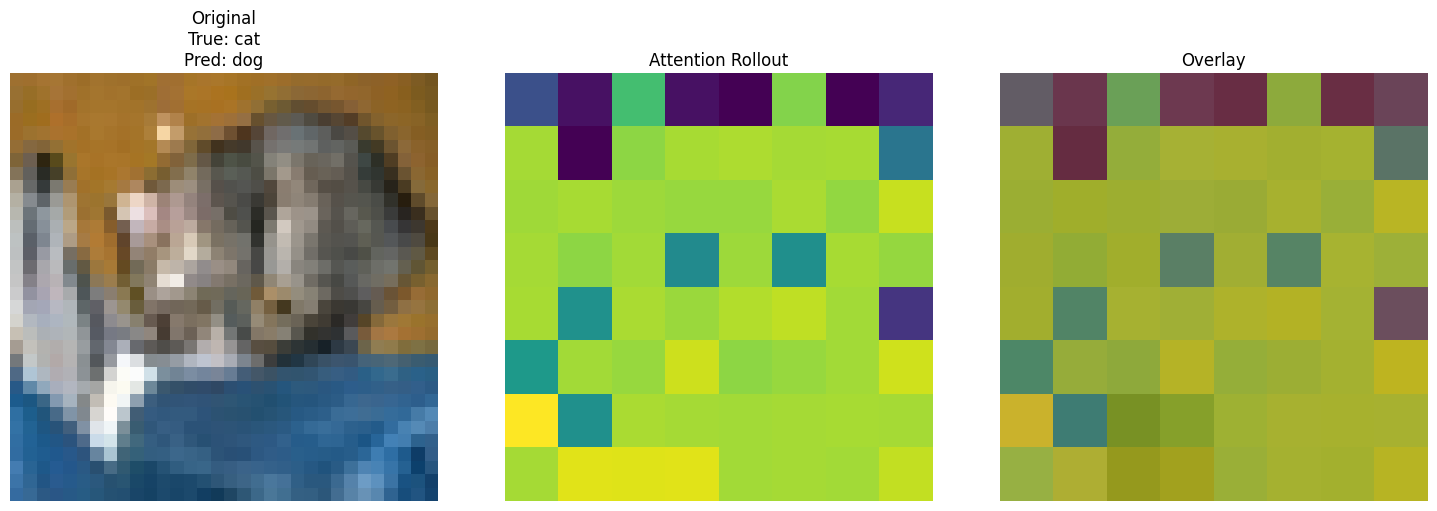

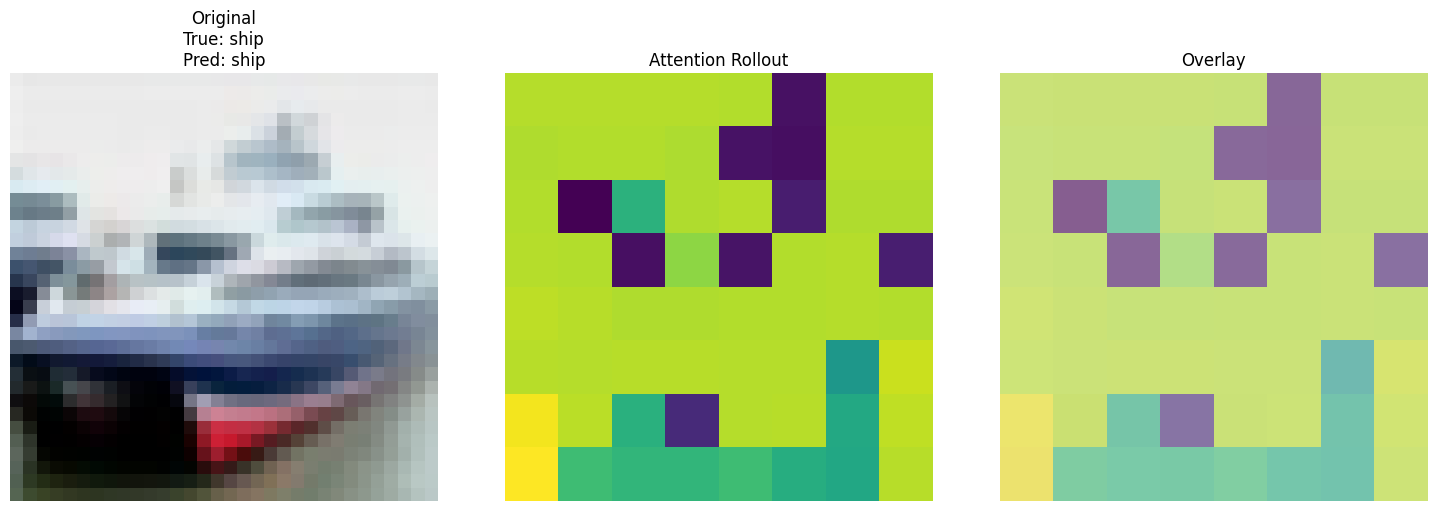

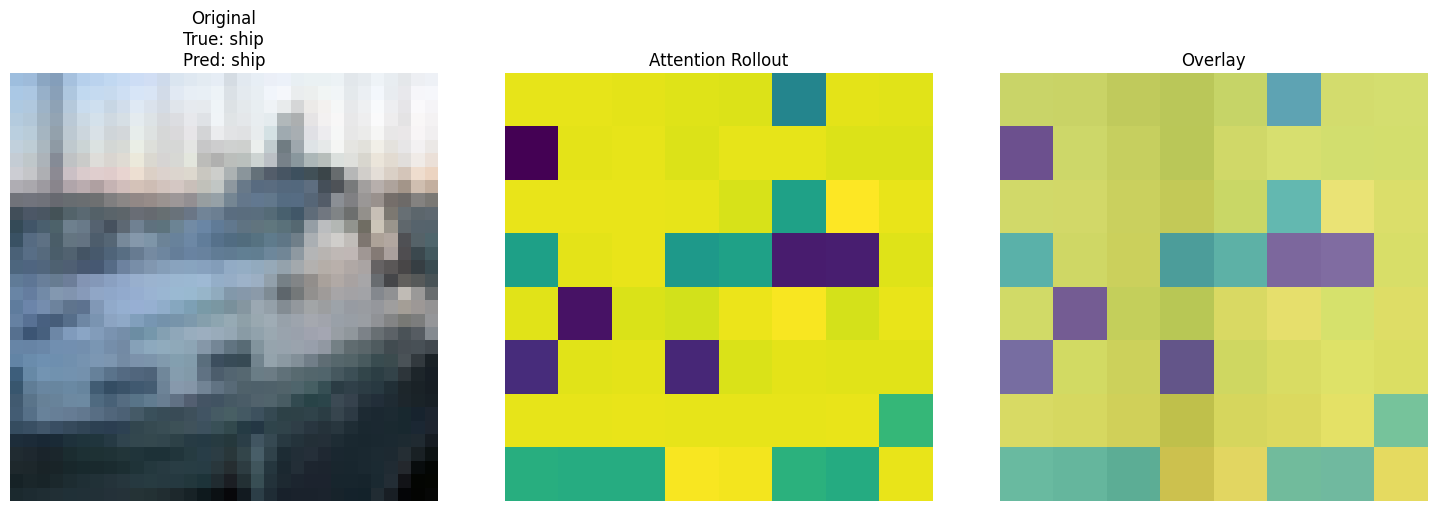

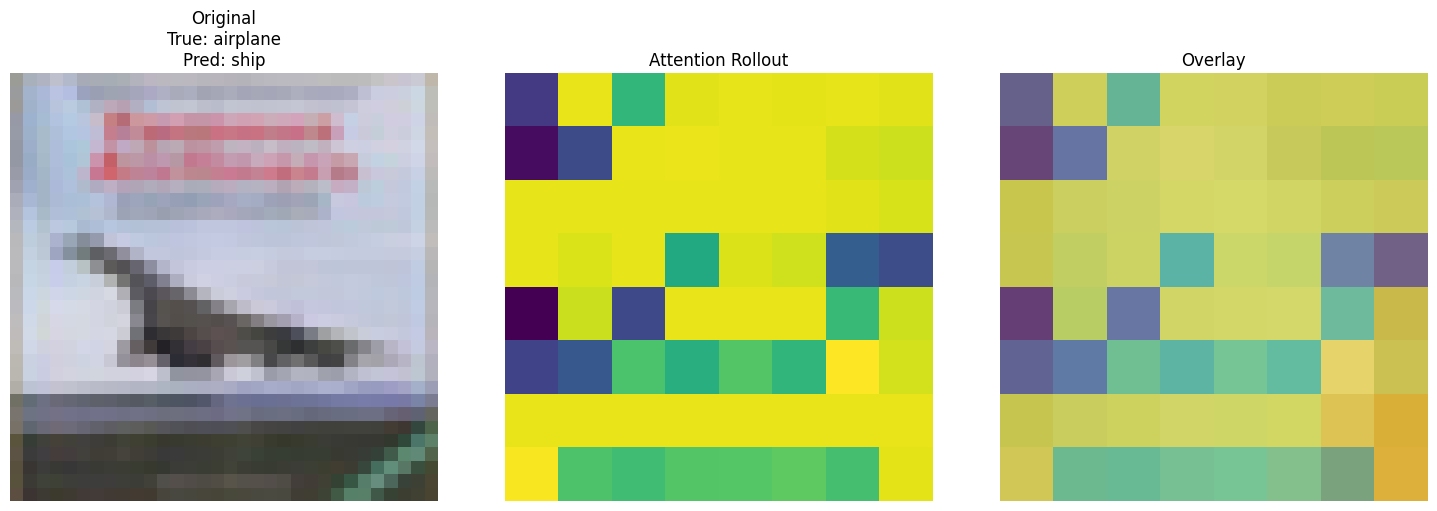

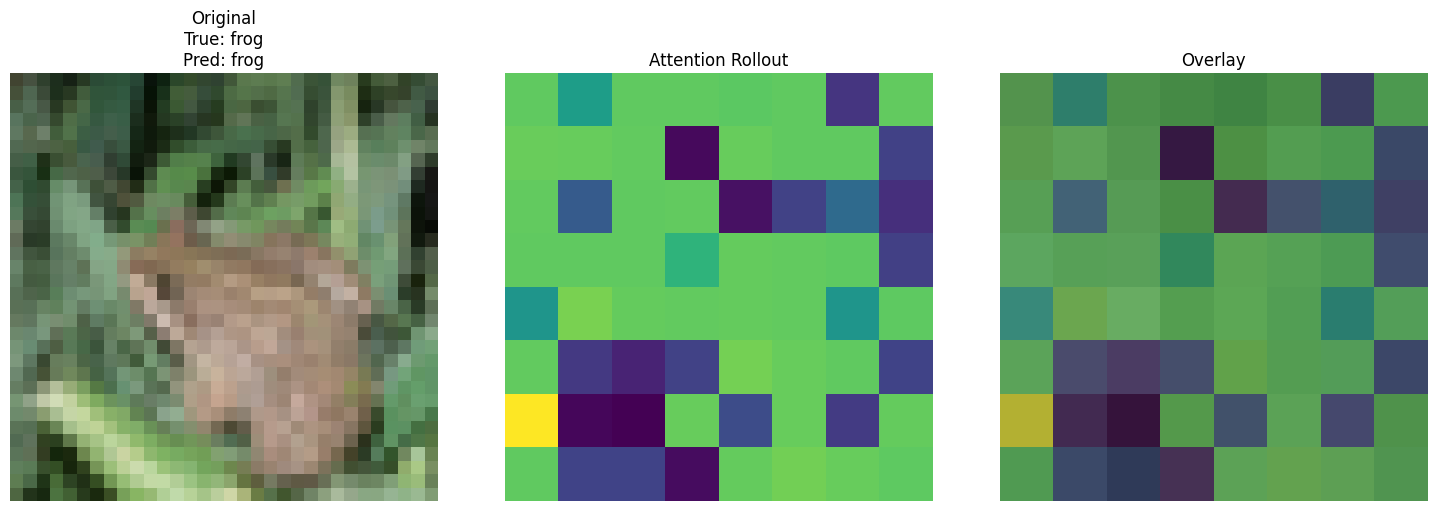

For DINO attention visualization:
To visualize DINO attention maps, use the provided implementation from the DINO repository.
Run visualize_attention.py with your chosen images as specified in the task.
Visualizing positional embeddings...

Total execution time: 50.99 seconds (0.85 minutes)


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.optim import Adam
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import functional as F
from tqdm import tqdm


class PatchEmbedding(nn.Module):
    def __init__(self, d_model, img_size, patch_size, n_channels):
        super().__init__()
        
        self.d_model = d_model
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_channels = n_channels
        
        # Number of patches
        self.n_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])
        
        # Linear projection of patches
        self.projection = nn.Conv2d(
            n_channels, d_model, 
            kernel_size=patch_size, 
            stride=patch_size
        )
        
        # Layer normalization
        self.norm = nn.LayerNorm(d_model)
        
    def forward(self, x):
        # Project patches: (batch_size, n_channels, height, width) -> (batch_size, d_model, h', w')
        x = self.projection(x)
        
        # Flatten patches: (batch_size, d_model, h', w') -> (batch_size, d_model, n_patches)
        x = x.flatten(2)
        
        # Transpose: (batch_size, d_model, n_patches) -> (batch_size, n_patches, d_model)
        x = x.transpose(1, 2)
        
        # Apply normalization
        x = self.norm(x)
        
        return x

class DifferentialAttention(nn.Module):
    def __init__(self, dim, num_heads, qkv_bias=True, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        self.d_model = dim

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        self.lambda_q1 = nn.Parameter(torch.zeros(head_dim, dtype=torch.float32).normal_(mean=0, std=0.02))
        self.lambda_k1 = nn.Parameter(torch.zeros(head_dim, dtype=torch.float32).normal_(mean=0, std=0.02))
        self.lambda_q2 = nn.Parameter(torch.zeros(head_dim, dtype=torch.float32).normal_(mean=0, std=0.02))
        self.lambda_k2 = nn.Parameter(torch.zeros(head_dim, dtype=torch.float32).normal_(mean=0, std=0.02))
        self.lambda_init = 0.5  # You can experiment with different initializations

        self.attn_weights = None  # Add this line

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)

        # Split Q and K for differential attention
        q1, q2 = q.chunk(2, dim=-1)
        k1, k2 = k.chunk(2, dim=-1)

        # Original attention mechanism
        attn1 = (q1 @ k1.transpose(-2, -1)) * self.scale
        attn1 = attn1.softmax(dim=-1)
        attn1 = self.attn_drop(attn1)

        attn2 = (q2 @ k2.transpose(-2, -1)) * self.scale
        attn2 = attn2.softmax(dim=-1)
        attn2 = self.attn_drop(attn2)

        # Calculate lambda
        lambda_1 = torch.exp(torch.sum(self.lambda_q1 * self.lambda_k1, dim=-1)).unsqueeze(0).unsqueeze(0)
        lambda_2 = torch.exp(torch.sum(self.lambda_q2 * self.lambda_k2, dim=-1)).unsqueeze(0).unsqueeze(0)
        lambda_full = lambda_1 - lambda_2 + self.lambda_init
        lambda_full = lambda_full.to(attn1.device)  # Ensure lambda is on the same device

        # Differential attention
        attn = attn1 - lambda_full * attn2
        attn = attn.softmax(dim=-1) # Apply softmax after subtraction

        self.attn_weights = attn # Store attention weights

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class TransformerEncoder(nn.Module):
    def __init__(self, d_model, n_heads, mlp_ratio=4, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        
        # Replace MultiHeadAttention with DifferentialAttention
        self.attn = DifferentialAttention(d_model, n_heads, qkv_bias=True, attn_drop=dropout, proj_drop=dropout)
        
        # Normalization layers
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        
        # MLP block
        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model * mlp_ratio),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * mlp_ratio, d_model),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        # First sub-layer: Differential attention with residual connection
        residual = x
        x = self.ln1(x)  # Pre-norm architecture
        x = self.attn(x)
        
        # Get attention weights for visualization
        attentions = self.attn.attn_weights
        
        x = residual + x
        
        # Second sub-layer: MLP with residual connection
        residual = x
        x = self.ln2(x)  # Pre-norm architecture
        x = self.mlp(x)
        x = residual + x
        
        return x, attentions


class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super().__init__()
        
        # Create the [CLS] token
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        
        # Create sinusoidal positional encoding
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length).unsqueeze(1).float()
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model)
        )
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Register the positional encoding as a buffer (not a parameter)
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Add CLS token to the sequence
        cls_tokens = self.cls_token.expand(batch_size, 1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        
        # Add positional encoding
        x = x + self.pe[:, :x.size(1)]
        
        return x

class LearnedPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super().__init__()
        
        # Create the [CLS] token
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        
        # Create learnable positional embeddings
        self.pos_embedding = nn.Parameter(torch.randn(1, max_seq_length, d_model))
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Add CLS token to the sequence
        cls_tokens = self.cls_token.expand(batch_size, 1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        
        # Add positional embedding
        x = x + self.pos_embedding[:, :x.size(1)]
        
        return x

class Learned2DPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length, grid_size):
        super().__init__()
        
        # Create the [CLS] token
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        
        # Grid size is (height, width) of the grid of patches
        h, w = grid_size
        
        # Create separate position embeddings for height and width
        self.pos_embedding_h = nn.Parameter(torch.randn(1, h, d_model // 2))
        self.pos_embedding_w = nn.Parameter(torch.randn(1, w, d_model // 2))
        
        # For CLS token
        self.cls_pos_embedding = nn.Parameter(torch.randn(1, 1, d_model))
        
    def forward(self, x):
        batch_size = x.size(0)
        seq_length = x.size(1)
        
        # Add CLS token to the sequence
        cls_tokens = self.cls_token.expand(batch_size, 1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        
        # For the CLS token, use a special position embedding
        cls_pos = self.cls_pos_embedding.expand(batch_size, 1, -1)
        
        # For the patch tokens
        grid_h, grid_w = int(np.sqrt(seq_length)), int(np.sqrt(seq_length))
        
        # Reshape to 2D grid
        patch_tokens = x[:, 1:].view(batch_size, grid_h, grid_w, -1)
        
        # Get position embeddings for each spatial dimension
        pos_h = self.pos_embedding_h.expand(batch_size, -1, -1)
        pos_w = self.pos_embedding_w.expand(batch_size, -1, -1)
        
        # Combine position embeddings
        pos_h = pos_h.unsqueeze(2).expand(-1, -1, grid_w, -1)
        pos_w = pos_w.unsqueeze(1).expand(-1, grid_h, -1, -1)
        
        # Concatenate the h and w position embeddings
        patch_pos = torch.cat([pos_h, pos_w], dim=-1)
        
        # Add positional embeddings to patch tokens
        patch_tokens = patch_tokens + patch_pos
        
        # Flatten back to sequence
        patch_tokens = patch_tokens.view(batch_size, grid_h * grid_w, -1)
        
        # Combine with CLS token
        x = torch.cat([cls_tokens + cls_pos, patch_tokens], dim=1)
        
        return x

class VisionTransformer(nn.Module):
    def __init__(
        self, 
        d_model, 
        n_classes, 
        img_size, 
        patch_size, 
        n_channels, 
        n_heads, 
        n_layers,
        mlp_ratio=4,
        dropout=0.1,
        pos_embedding_type='1d_learned'
    ):
        super().__init__()
        
        # Validate input dimensions
        assert img_size[0] % patch_size[0] == 0, "Image height must be divisible by patch height"
        assert img_size[1] % patch_size[1] == 0, "Image width must be divisible by patch width"
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        
        # Store parameters
        self.d_model = d_model
        self.n_classes = n_classes
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.n_heads = n_heads
        self.n_layers = n_layers
        
        # Calculate number of patches
        self.n_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])
        self.max_seq_length = self.n_patches + 1  # +1 for CLS token
        
        # Patch embedding layer
        self.patch_embedding = PatchEmbedding(d_model, img_size, patch_size, n_channels)
        
        # Positional embedding
        grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        
        if pos_embedding_type == 'none':
            # Just add CLS token without positional embedding
            self.positional_encoding = nn.Module()
            self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
            
            def forward_none(x):
                batch_size = x.size(0)
                cls_tokens = self.cls_token.expand(batch_size, 1, -1)
                return torch.cat((cls_tokens, x), dim=1)
                
            self.positional_encoding.forward = forward_none
        elif pos_embedding_type == '1d_learned':
            self.positional_encoding = LearnedPositionalEncoding(d_model, self.max_seq_length)
        elif pos_embedding_type == '2d_learned':
            self.positional_encoding = Learned2DPositionalEncoding(d_model, self.max_seq_length, grid_size)
        elif pos_embedding_type == 'sinusoidal':
            self.positional_encoding = SinusoidalPositionalEncoding(d_model, self.max_seq_length)
        else:
            raise ValueError(f"Unknown positional embedding type: {pos_embedding_type}")
        
        # Input dropout
        self.dropout = nn.Dropout(dropout)
        
        # Transformer encoder layers
        self.transformer_layers = nn.ModuleList([
            TransformerEncoder(d_model, n_heads, mlp_ratio, dropout)
            for _ in range(n_layers)
        ])
        
        # Final layer normalization
        self.ln_f = nn.LayerNorm(d_model)
        
        # Classification head
        self.classifier = nn.Linear(d_model, n_classes)
        
        # Initialize weights
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)
            
    def forward(self, x):
        # Embed patches: (batch_size, n_channels, height, width) -> (batch_size, n_patches, d_model)
        x = self.patch_embedding(x)
        
        # Add positional embeddings
        x = self.positional_encoding(x)
        
        # Apply dropout
        x = self.dropout(x)
        
        # Store attention weights for visualization
        all_attentions = []
        
        # Apply transformer layers
        for layer in self.transformer_layers:
            x, attentions = layer(x)
            all_attentions.append(attentions)
        
        # Apply final layer norm
        x = self.ln_f(x)
        
        # Use CLS token for classification
        x = x[:, 0]
        
        # Apply classification head
        logits = self.classifier(x)
        
        return logits, all_attentions

class AttentionRollout:
    def __init__(self, model):
        self.model = model

    def forward(self, img, discard_ratio=0.9):
        # Get attention maps from the model
        self.model.eval()
        _ = self.model(img)
        attention_maps = self.model.get_attention_maps()

        # Rollout attention
        # We start from the last layer and move backwards
        # Initialize as a 3D tensor [batch_size, num_tokens, num_tokens]
        batch_size = attention_maps[-1].shape[0]
        num_tokens = attention_maps[-1].shape[-1]
        rolled_attention = torch.eye(num_tokens).unsqueeze(0).repeat(batch_size, 1, 1)
        rolled_attention = rolled_attention.to(attention_maps[-1].device)

        for attention_layer in reversed(attention_maps):
            # Average attention across all heads
            layer_attention = attention_layer.mean(dim=1)  # [B, N, N]

            # Apply discard ratio
            if discard_ratio > 0:
                flat_attention = layer_attention.view(layer_attention.shape[0], -1)
                _, indices = flat_attention.sort(descending=True, dim=-1)
                indices_to_discard = indices[:, int(flat_attention.shape[1] * discard_ratio):]

                # Create a mask to zero out lowest attention values
                flat_mask = torch.ones_like(flat_attention)
                for i in range(flat_mask.shape[0]):
                    flat_mask[i, indices_to_discard[i]] = 0

                # Reshape mask back to attention shape and apply
                attention_mask = flat_mask.view(layer_attention.shape)
                layer_attention = layer_attention * attention_mask

            # Add residual connection - now both tensors are [batch_size, num_tokens, num_tokens]
            rolled_attention = torch.bmm(layer_attention, rolled_attention)

        # Get attention from CLS token to patches
        # First row corresponds to attention from CLS token to all tokens (including CLS token)
        cls_attention = rolled_attention[:, 0, 1:]  # Remove attention to CLS token itself

        return cls_attention

def get_cifar10_dataloaders(batch_size=64, augmentation=None):
    # Default transforms
    if augmentation is None:
        transform_train = T.Compose([
            T.ToTensor(),
            T.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
        ])
    else:
        transform_train = augmentation
        
    transform_test = T.Compose([
        T.ToTensor(),
        T.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])
    
    # Load datasets
    train_set = CIFAR10(root="./data", train=True, download=True, transform=transform_train)
    test_set = CIFAR10(root="./data", train=False, download=True, transform=transform_test)
    
    # Create data loaders
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    return train_loader, test_loader

def train(model, train_loader, optimizer, criterion, device, scheduler=None):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc="Training", leave=False)
    
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs, _ = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Update learning rate if scheduler is provided
        if scheduler is not None:
            scheduler.step()
        
        # Calculate statistics
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': total_loss / (progress_bar.n + 1),
            'acc': 100 * correct / total
        })
    
    avg_loss = total_loss / len(train_loader)
    train_acc = 100 * correct / total
    
    return avg_loss, train_acc

def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs, _ = model(inputs)
            loss = criterion(outputs, labels)
            
            # Calculate statistics
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy

def train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, device, epochs, scheduler=None):
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    best_accuracy = 0.0
    best_model_path = "best_vit_model.pth"
    
    for epoch in range(epochs):
        # Train model
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device, scheduler)
        
        # Evaluate model
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)
        
        # Store metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")
        
        # Save model if test accuracy improves
        if test_acc > best_accuracy:
            best_accuracy = test_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"Saving Best Model at Epoch {epoch+1} with Accuracy: {best_accuracy:.2f}%")
    
    print(f"\nBest Test Accuracy: {best_accuracy:.2f}% — Model saved to: {best_model_path}")
    
    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs,
        'best_accuracy': best_accuracy
    }

def plot_metrics(metrics):
    epochs = range(1, len(metrics['train_losses']) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Plot training and test loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics['train_losses'], 'b-', label='Training Loss')
    plt.plot(epochs, metrics['test_losses'], 'r-', label='Test Loss')
    plt.title('Training and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot training and test accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics['train_accs'], 'b-', label='Training Accuracy')
    plt.plot(epochs, metrics['test_accs'], 'r-', label='Test Accuracy')
    plt.title('Training and Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('vit_metrics.png')
    plt.show()

def visualize_positional_embedding(model):
    """Visualize the learned positional embeddings"""
    if hasattr(model.pos_embed, "pos_embed"):
        pos_embed = model.pos_embed.pos_embed.detach().cpu().numpy()[0]

        # Remove cls token positional embedding
        pos_embed = pos_embed[1:]

        # Calculate similarity (dot product)
        similarity = np.dot(pos_embed, pos_embed.T)

        # Plot
        fig = plt.figure(figsize=(10, 8))
        plt.imshow(similarity, cmap='viridis')
        plt.colorbar()
        plt.title("Positional Embedding Similarity")
        plt.tight_layout()
        return fig  # Return the figure
    else:
        print("No learnable positional embeddings found.")
        return None

def visualize_attention_maps(model, dataloader, num_images=5, device='cuda'):
    """Visualize attention maps for the first num_images from dataloader"""
    model.eval()

    # Get a batch of images
    images, labels = next(iter(dataloader))
    images = images[:num_images].to(device)
    labels = labels[:num_images]

    # Get predictions
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    # Get class names
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

    # Get attention maps
    attention_maps = model.get_attention_maps()

    # Plot original images and attention maps
    for i in range(num_images):
        plt.figure(figsize=(20, 5))

        # Original image
        plt.subplot(1, len(model.blocks) + 2, 1)
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = img * np.array([0.2470, 0.2435, 0.2616]) + np.array([0.4914, 0.4822, 0.4465])
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(f"Original\nTrue: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
        plt.axis('off')

        # Attention from last layer (avg across heads)
        plt.subplot(1, len(model.blocks) + 2, 2)
        attn = attention_maps[-1][i].mean(0)[0, 1:].reshape((32 // model.patch_size), (32 // model.patch_size))
        plt.imshow(attn.cpu().numpy(), cmap='viridis')
        plt.title(f"Last Layer Attn\n(Avg Heads)")
        plt.axis('off')

        # Attention from each layer
        for j, block_attn in enumerate(attention_maps):
            # CLS token attention to patch tokens
            attn = block_attn[i].mean(0)[0, 1:].reshape((32 // model.patch_size), (32 // model.patch_size))
            plt.subplot(1, len(model.blocks) + 2, j + 3)
            plt.imshow(attn.cpu().numpy(), cmap='viridis')
            plt.title(f"Layer {j+1}")
            plt.axis('off')

        plt.tight_layout()
        plt.show()

def visualize_attention_rollout(model, dataloader, num_images=5, device='cuda'):
    """Visualize attention rollout maps"""
    model.eval()
    rollout = AttentionRollout(model)

    # Get a batch of images
    images, labels = next(iter(dataloader))
    images = images[:num_images].to(device)
    labels = labels[:num_images]

    # Get predictions
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    # Get class names
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

    # Get attention rollout maps
    attention_rollout_maps = []
    for i in range(num_images):
        attention_rollout_maps.append(rollout.forward(images[i:i+1]))

    # Plot original images and attention rollout maps
    for i in range(num_images):
        plt.figure(figsize=(15, 5))

        # Original image
        plt.subplot(1, 3, 1)
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = img * np.array([0.2470, 0.2435, 0.2616]) + np.array([0.4914, 0.4822, 0.4465])
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(f"Original\nTrue: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
        plt.axis('off')

        # Attention rollout
        plt.subplot(1, 3, 2)
        rollout_map = attention_rollout_maps[i][0].reshape((32 // model.patch_size), (32 // model.patch_size))
        plt.imshow(rollout_map.cpu().detach().numpy(), cmap='viridis')
        plt.title("Attention Rollout")
        plt.axis('off')

        # Overlay
        plt.subplot(1, 3, 3)
        plt.imshow(img)
        plt.imshow(rollout_map.cpu().detach().numpy(), cmap='viridis', alpha=0.6)
        plt.title("Overlay")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

def experiment_positional_embeddings():
    """Experiment with different positional embedding types"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Best configuration from previous experiments
    # (using the best configuration from hyperparameter and augmentation experiments)
    best_config = {
        "patch_size": 4,
        "embed_dim": 192,
        "depth": 12,
        "num_heads": 6,
        "mlp_ratio": 2.0,
        "drop_rate": 0.1
    }

    # Best augmentation from previous experiments
    # (assuming AutoAugment was the best)
    best_augmentation = transforms.Compose([
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])

    # Different positional embedding types
    pos_embed_types = ['none', '1d_learned', '2d_learned', 'sinusoidal']
    pos_embed_names = ['No Positional Embedding', '1D Learned', '2D Learned', 'Sinusoidal']

    results = {}

    for pos_embed_type, pos_embed_name in zip(pos_embed_types, pos_embed_names):
        print(f"\nTraining with {pos_embed_name} positional embedding:")

        # Initialize model with the best config and current positional embedding type
        model = VisionTransformer(
            img_size=32,
            patch_size=best_config["patch_size"],
            in_channels=3,
            num_classes=10,
            embed_dim=best_config["embed_dim"],
            depth=best_config["depth"],
            num_heads=best_config["num_heads"],
            mlp_ratio=best_config["mlp_ratio"],
            qkv_bias=True,
            drop_rate=best_config["drop_rate"],
            attn_drop_rate=0.0,
            pos_embed_type=pos_embed_type
        ).to(device)

        # Get dataloaders with the best augmentation
        trainloader, testloader = get_cifar10_dataloaders(batch_size=128, augmentations=best_augmentation)

        # Loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.05)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

        # Train and evaluate
        result = train_and_evaluate(
            model=model,
            trainloader=trainloader,
            testloader=testloader,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            num_epochs=50,
            device=device,
            save_path=f"vit_{pos_embed_type}.pth"
        )

        results[pos_embed_name] = result

        # Plot and save loss curves
        fig = plot_loss_curves(result, title=f"ViT with {pos_embed_name}")
        fig.savefig(f"loss_curves_{pos_embed_type}.png")
        plt.close(fig)

        # Visualize positional embeddings if learned
        if pos_embed_type in ['1d_learned', '2d_learned']:
            fig = visualize_positional_embedding(model)
            if fig is not None:
                fig.savefig(f"pos_embed_viz_{pos_embed_type}.png")
                plt.close(fig)

        print(f"Best test accuracy with {pos_embed_name}: {result['best_acc']:.2f}%")

    # Compare results
    plt.figure(figsize=(12, 10))

    plt.subplot(2, 1, 1)
    for pos_embed_name in results:
        plt.plot(results[pos_embed_name]['test_losses'], label=pos_embed_name)
    plt.title("Test Loss Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2, 1, 2)
    for pos_embed_name in results:
        plt.plot(results[pos_embed_name]['test_accs'], label=pos_embed_name)
    plt.title("Test Accuracy Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.tight_layout()
    plt.savefig("pos_embed_comparison.png")
    plt.close()

    # Print best accuracies
    print("\nBest Test Accuracies:")
    for pos_embed_name in results:
        print(f"{pos_embed_name}: {results[pos_embed_name]['best_acc']:.2f}%")

    return results

def visualize_dino_attention():
    """Visualize DINO attention maps"""
    print("To visualize DINO attention maps, use the provided implementation from the DINO repository.")
    print("Run visualize_attention.py with your chosen images as specified in the task.")

def main():
    # Set random seed for reproducibility
    torch.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    np.random.seed(42)

    # Create output directory if it doesn't exist
    os.makedirs("outputs", exist_ok=True)

    # Record start time
    start_time = time.time()

    # 1. Experiment with different positional embeddings
    print("\n==== Experiment 4: Positional Embedding Types ====")
    pos_embed_results = experiment_positional_embeddings()

    # 2. Visualizations
    print("\n==== Experiment 5: Visualizations ====")

    # Load the best model (assuming the one with 1D learned positional embedding was best)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_model = VisionTransformer(
        img_size=32,
        patch_size=4,
        in_channels=3,
        num_classes=10,
        embed_dim=192,
        depth=12,
        num_heads=6,
        mlp_ratio=2.0,
        qkv_bias=True,
        drop_rate=0.1,
        attn_drop_rate=0.0,
        pos_embed_type='1d_learned'
    ).to(device)

    # Load the saved state dict
    best_model.load_state_dict(torch.load("vit_1d_learned.pth"))

    # Get dataloaders
    _, testloader = get_cifar10_dataloaders(batch_size=64)

    # Visualize attention maps
    print("Visualizing attention maps...")
    visualize_attention_maps(best_model, testloader, num_images=5, device=device)

    # Visualize attentioon rollout
    print("Visualizing attention rollout...")
    visualize_attention_rollout(best_model, testloader, num_images=5, device=device)

    # Visualize DINO attention
    print("For DINO attention visualization:")
    visualize_dino_attention()

    # Visualize positional embeddings
    print("Visualizing positional embeddings...")
    fig = visualize_positional_embedding(best_model)
    if fig is not None:
        fig.savefig("pos_embed_viz_final.png")
        plt.close(fig)

    # Print total execution time
    total_time = time.time() - start_time
    print(f"\nTotal execution time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")

if __name__ == "__main__":
    main()